In [1]:
import adult_data_functions as af
import numpy as np
import tensorflow as tf
# import os 
# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

In [2]:
tf.random.set_seed(0)
np.random.seed(0)

# Process Data

In [3]:
# Load data
categorical_feature_encoder = preprocessing.OneHotEncoder()
sex_encoder = preprocessing.LabelEncoder() 
income_encoder = preprocessing.LabelEncoder()

merge_country_boolean=False
merge_education_boolean=False

train_data_dict = af.preprocess(adult_dt_path="data/adult.data", 
                                categorical_feature_encoder=categorical_feature_encoder, 
                                sex_encoder=sex_encoder,
                                income_encoder=income_encoder, encoder_fit_boolean=True,
                               merge_country_boolean=merge_country_boolean, 
                               merge_education_boolean=merge_education_boolean)

In [4]:
import pandas as pd
pd.Series(train_data_dict["income-label"]).value_counts(normalize=True)

0    0.751078
1    0.248922
dtype: float64

In [5]:
pd.Series(train_data_dict["sex"]).value_counts(normalize=True)

1    0.675685
0    0.324315
dtype: float64

## Train Validation Split

In [6]:
indices_array = np.arange(train_data_dict["income-label"].shape[0])
len(indices_array)

30162

In [7]:
# split based on income
indices_array = np.arange(train_data_dict["income-label"].shape[0])
train_indices_array, val_indices_array = train_test_split(indices_array, 
                                                           stratify=train_data_dict["income-label"], 
                                                           test_size=0.1, 
                                                           random_state=0)

In [8]:
from sklearn.preprocessing import StandardScaler
train_feature_mat = np.hstack([train_data_dict["categorical-features"][train_indices_array, :].toarray(), 
               train_data_dict["continuous-features"][train_indices_array, :]])
val_feature_mat = np.hstack([train_data_dict["categorical-features"][val_indices_array, :].toarray(), 
               train_data_dict["continuous-features"][val_indices_array, :]])

scaler = StandardScaler()

scaled_train_feature_mat = scaler.fit_transform(train_feature_mat)
scaled_val_feature_mat = scaler.fit_transform(val_feature_mat)

In [9]:
from sklearn.decomposition import PCA
pca = PCA(n_components=scaled_train_feature_mat.shape[1] - 5)
train_pca_x_mat = pca.fit_transform(scaled_train_feature_mat)
val_pca_x_mat = pca.transform(scaled_val_feature_mat)

In [10]:
# Prepare x_y_mat (sex, income)
x_y_mat = np.hstack([train_data_dict["sex"].reshape(-1, 1), train_data_dict["income-label"].reshape(-1, 1)])
x_y_mat = 2 * x_y_mat - 1

train_dataset = tf.data.Dataset.from_tensor_slices((train_pca_x_mat, x_y_mat[train_indices_array, :]))
val_dataset = tf.data.Dataset.from_tensor_slices((val_pca_x_mat, x_y_mat[val_indices_array, :]))

2022-05-04 12:45:38.570997: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [11]:
buffer_size = 50000
batch_size = 20000

train_dataset = train_dataset.shuffle(buffer_size).batch(batch_size)
val_dataset = val_dataset.shuffle(buffer_size).batch(batch_size)

In [12]:
pd.Series(x_y_mat[train_indices_array, 0]).value_counts(normalize=True)

 1    0.675041
-1    0.324959
dtype: float64

In [13]:
pd.Series(x_y_mat[val_indices_array, 0]).value_counts(normalize=True)

 1    0.681472
-1    0.318528
dtype: float64

# Training

In [14]:
# for n_layers in [0, 1, 5]:
#     for l2 in [0.0001, 0.001, 0.1, 0, 1, 10, 100]:
#         model = af.ModelNetwork(n_layers=n_layers, hidden_dim=59, final_dim=59, output_dim=3, 
#                                 education_dim=None, occupation_dim=None,
#                        final_layer_regularizer=tf.keras.regularizers.L2(l2))
        
#         learning_rate = tf.keras.optimizers.schedules.PiecewiseConstantDecay(boundaries=[2,50], 
#                                                                              values=[0.01, 0.001, 0.0001])
#         epochs=500
#         optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
        
#         model.compile(optimizer=optimizer,
#               loss=af.ising_likelihood,
#               run_eagerly=True)

#         callbacks = [
#             tf.keras.callbacks.EarlyStopping(
#                 # Stop training when `val_loss` is no longer improving
#                 monitor="val_loss",
#                 # "no longer improving" being defined as "no better than 1e-2 less"
#                 min_delta=1e-2,
#                 # "no longer improving" being further defined as "for at least 2 epochs"
#                 patience=3,
#                 verbose=1,
#             ),
#             tf.keras.callbacks.ModelCheckpoint(
#                 # Path where to save the model
#                 # The two parameters below mean that we will overwrite
#                 # the current checkpoint if and only if
#                 # the `val_loss` score has improved.
#                 # The saved model name will include the current epoch.
#                 filepath=f"saved_model/model_n_layer:{n_layers}_l2:{l2}_drop:{0.8}",
#                 save_best_only=True,  # Only save a model if `val_loss` has improved.
#                 monitor="val_loss",
#                 verbose=1,
#             )
#         ]
        
#         model.fit(train_dataset, epochs=epochs, validation_data=val_dataset, callbacks=callbacks)

In [15]:
f1_sex_metric = af.Metric(name="f1", response_name="sex")
f1_income_metric = af.Metric(name="f1", response_name="income-label")
accuracy_sex_metric = af.Metric(name="accuracy", response_name="sex")
accuracy_income_metric = af.Metric(name="accuracy", response_name="income-label")

In [16]:
l2 = 0
model = af.ModelNetwork(n_layers=0, hidden_dim=79, l_dim=79, output_dim=2, l2=l2)

learning_rate = tf.keras.optimizers.schedules.PiecewiseConstantDecay(boundaries=[10, 15], 
                                                                     values=[0.1, 0.01, 0.001])
# learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss=af.ising_likelihood, 
              metrics=[f1_sex_metric, f1_income_metric, accuracy_sex_metric, accuracy_income_metric],
             run_eagerly=True)

In [17]:
epochs=30

# tf.keras.callbacks.EarlyStopping(
#         # Stop training when `val_loss` is no longer improving
#         monitor="val_loss",
#         # "no longer improving" being defined as "no better than 1e-2 less"
#         min_delta=1e-2,
#         # "no longer improving" being further defined as "for at least 2 epochs"
#         patience=10,
#         verbose=1,
#     ),
# callbacks = [
    
#     tf.keras.callbacks.ModelCheckpoint(
#         # Path where to save the model
#         # The two parameters below mean that we will overwrite
#         # the current checkpoint if and only if
#         # the `val_loss` score has improved.
#         # The saved model name will include the current epoch.
#         filepath=f"saved_model/model_l2:{l2}_epochs:{epochs}",
#         save_best_only=True,  # Only save a model if `val_loss` has improved.
#         monitor="val_loss",
#         verbose=1,
#     )
# ]

In [18]:
history = model.fit(train_dataset, epochs=epochs, validation_data=val_dataset)

Epoch 1/30
2/2 [==============================] - 7s 1s/step - loss: 2.1475 - f1_sex: 0.5883 - f1_income-label: 0.3258 - accuracy_sex: 0.6834 - accuracy_income-label: 0.5262 - val_loss: 1.2760 - val_f1_sex: 0.5916 - val_f1_income-label: 0.4610 - val_accuracy_sex: 0.7080 - val_accuracy_income-label: 0.7047
Epoch 2/30
2/2 [==============================] - 3s 929ms/step - loss: 1.2427 - f1_sex: 0.5927 - f1_income-label: 0.5034 - accuracy_sex: 0.7129 - accuracy_income-label: 0.7460 - val_loss: 1.1847 - val_f1_sex: 0.5641 - val_f1_income-label: 0.5115 - val_accuracy_sex: 0.7183 - val_accuracy_income-label: 0.7531
Epoch 3/30
2/2 [==============================] - 3s 916ms/step - loss: 1.1665 - f1_sex: 0.5655 - f1_income-label: 0.5279 - accuracy_sex: 0.7159 - accuracy_income-label: 0.7657 - val_loss: 1.0949 - val_f1_sex: 0.5430 - val_f1_income-label: 0.5682 - val_accuracy_sex: 0.7232 - val_accuracy_income-label: 0.7819
Epoch 4/30
2/2 [==============================] - 3s 929ms/step - loss: 1

2/2 [==============================] - 17s 912ms/step - loss: 0.9506 - f1_sex: 0.5218 - f1_income-label: 0.5675 - accuracy_sex: 0.7450 - accuracy_income-label: 0.8104 - val_loss: 0.9681 - val_f1_sex: 0.5224 - val_f1_income-label: 0.5699 - val_accuracy_sex: 0.7491 - val_accuracy_income-label: 0.8114
Epoch 28/30
2/2 [==============================] - 3s 951ms/step - loss: 0.9491 - f1_sex: 0.5361 - f1_income-label: 0.5457 - accuracy_sex: 0.7467 - accuracy_income-label: 0.8066 - val_loss: 0.9666 - val_f1_sex: 0.5243 - val_f1_income-label: 0.5712 - val_accuracy_sex: 0.7498 - val_accuracy_income-label: 0.8124
Epoch 29/30
2/2 [==============================] - 6s 914ms/step - loss: 0.9476 - f1_sex: 0.5334 - f1_income-label: 0.5566 - accuracy_sex: 0.7416 - accuracy_income-label: 0.8129 - val_loss: 0.9652 - val_f1_sex: 0.5230 - val_f1_income-label: 0.5710 - val_accuracy_sex: 0.7491 - val_accuracy_income-label: 0.8127
Epoch 30/30
2/2 [==============================] - 4s 925ms/step - loss: 0.946

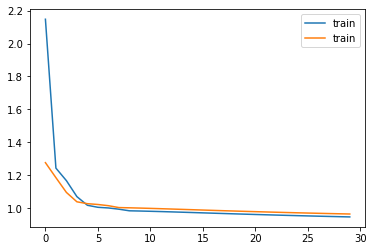

In [19]:
import matplotlib.pyplot as plt
plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="train")
plt.legend()

In [20]:
test_data_dict = af.preprocess(adult_dt_path="data/adult.test", 
                                categorical_feature_encoder=categorical_feature_encoder, 
                                sex_encoder=sex_encoder,
                                income_encoder=income_encoder, encoder_fit_boolean=False,
                               merge_country_boolean=merge_country_boolean, 
                               merge_education_boolean=merge_education_boolean)

test_feature_mat = np.hstack([test_data_dict["categorical-features"].toarray(), 
               test_data_dict["continuous-features"]])

scaled_test_feature_mat = scaler.transform(test_feature_mat)
test_pca_x_mat = pca.transform(scaled_test_feature_mat)

test_x_y_mat = np.hstack([test_data_dict["sex"].reshape(-1, 1), test_data_dict["income-label"].reshape(-1, 1)])
test_x_y_mat = 2 * test_x_y_mat - 1
test_dataset = tf.data.Dataset.from_tensor_slices((test_pca_x_mat, test_x_y_mat)).batch(batch_size)

In [21]:
af.tf_score_summary(model=model, dataset=test_dataset)

,accuracy,precision,recall,f1
sex-1,0.746215,0.673010,0.431915,0.526159
income1,0.807968,0.647016,0.480541,0.551489


In [22]:
# Reduced _Model
l2 = 0
reduced_model = af.ModelNetwork(n_layers=0, hidden_dim=70, l_dim=70, output_dim=2, l2=l2)

learning_rate = tf.keras.optimizers.schedules.PiecewiseConstantDecay(boundaries=[8, 13], 
                                                                     values=[0.1, 0.01, 0.001])
# learning_rate = 0.0001
reduced_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss=af.ising_likelihood, 
              metrics=[f1_sex_metric, f1_income_metric, accuracy_sex_metric, accuracy_income_metric],
             run_eagerly=True)

epochs=20
callbacks = [
    
    tf.keras.callbacks.ModelCheckpoint(
        # Path where to save the model
        # The two parameters below mean that we will overwrite
        # the current checkpoint if and only if
        # the `val_loss` score has improved.
        # The saved model name will include the current epoch.
        filepath=f"saved_model/model_l2:{l2}_epochs:{epochs}",
        save_best_only=True,  # Only save a model if `val_loss` has improved.
        monitor="val_loss",
        verbose=1,
    )
]

history = reduced_model.fit(train_dataset, epochs=epochs, validation_data=val_dataset)

Epoch 1/20
2/2 [==============================] - 5s 938ms/step - loss: 1.9980 - f1_sex: 0.5001 - f1_income-label: 0.5086 - accuracy_sex: 0.6189 - accuracy_income-label: 0.6873 - val_loss: 1.2202 - val_f1_sex: 0.5700 - val_f1_income-label: 0.5531 - val_accuracy_sex: 0.6894 - val_accuracy_income-label: 0.7295
Epoch 2/20
2/2 [==============================] - 8s 948ms/step - loss: 1.1951 - f1_sex: 0.5815 - f1_income-label: 0.5868 - accuracy_sex: 0.7106 - accuracy_income-label: 0.7775 - val_loss: 1.1536 - val_f1_sex: 0.5710 - val_f1_income-label: 0.5509 - val_accuracy_sex: 0.7176 - val_accuracy_income-label: 0.7720
Epoch 3/20
2/2 [==============================] - 3s 1s/step - loss: 1.1376 - f1_sex: 0.5783 - f1_income-label: 0.5432 - accuracy_sex: 0.7302 - accuracy_income-label: 0.7877 - val_loss: 1.1473 - val_f1_sex: 0.5588 - val_f1_income-label: 0.5393 - val_accuracy_sex: 0.7252 - val_accuracy_income-label: 0.7922
Epoch 4/20
2/2 [==============================] - 3s 989ms/step - loss: 1

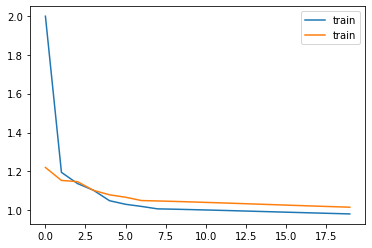

In [23]:
plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="train")
plt.legend()

In [24]:
af.tf_score_summary(model=reduced_model, dataset=test_dataset)

,accuracy,precision,recall,f1
sex-1,0.744090,0.641389,0.488907,0.554863
income1,0.813612,0.690568,0.437297,0.535496


# P-Value

In [25]:
import test_statistic as ts

In [26]:
score_test = ts.ScoreTest(x_y_mat=train_pca_x_mat, 
                          j_mat=reduced_model(train_pca_x_mat).numpy(), 
                          final_linear_input_mat=train_feature_mat, 
                          network_weights_vet=reduced_model.weights, 
                          sandwich_boolean=False)

In [27]:
p_value = score_test.p_value(n_batches=5, batch_size=200)

In [28]:
p_value

0.0

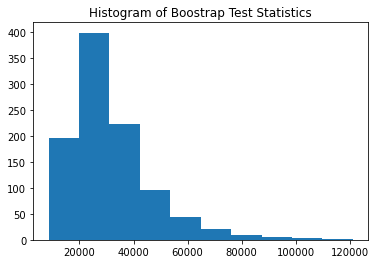

In [34]:
import matplotlib.pyplot as plt
plt.hist(score_test.boostrap_ts_vet)
plt.title("Histogram of Boostrap Test Statistics");

In [35]:
score_test.test_statistic

2909292.973091906